# AEWS Python Notebook 08d: AEWS miscellanea

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: June 07, 2016.

**Note**: The Python code below is "rudimentary" etc. etc. Priority is here given to code interpretability rather than execution efficiency.

**Note**: this notebook should be accessible and viewable at [https://github.com/eric542/agdc_v2/tree/master/notebooks](https://github.com/eric542/agdc_v2/tree/master/notebooks).

## Summary

Building up on the concepts introduced in the previous notebooks in this series, we work out the remaining components of the AEWS implementation -- see *'AEWS Python Notebook 08a'* for details of these components. The contents summary for the present notebook is given below.

**Abstract $-$** Following up from the discussion of results in _"AEWS Python Notebook 08c"_, this notebook (08d) investigates in more detail the .shp file of lakes' polygons provided by DPI Water. We show how this dataset can be used to derive a "polygon mask" for each lake of interest, thereby providing the lakes' extents and allowing for the derivation of low-water flags (in a more robust manner compared to the use of WOFS data). The notebook also investigates the best (fastest) way of creating the polygon mask from vector data.


## Preliminaries

This (Jupyter) notebook was written for use on the NCI's VDI system, with the following pre-loaded module:

```
 $ module use /g/data/v10/public/modules/modulefiles --append
 $ module load agdc-py2-prod 
```

**NOTE**: the specific module loaded here (`agdc-py2-prod`) is different from the module loaded in earlier notebooks (`agdc-py2-dev`)! While the earlier module contained only Landsat 5 data, the `agdc-py2-prod` module links to a (different) AGDC database containing the following NBART/NBAR/PQA datasets:

* Landsat 8: 2013
* Landsat 7: 2013
* Landsat 5: 2006/2007

It is unclear whether the API functions in these 2 modules are identical or represent different versions.

In [1]:
%%html  # Definitions for some pretty text boxes...
<style>
    div.warn { background-color: #e8c9c9; border-left: 5px solid #c27070; padding: 0.5em }
    div.note { background-color: #cce0ff; border-left: 5px solid #5c85d6; padding: 0.5em }
    div.info { background-color: #ffe680; border-left: 5px solid #cca300; padding: 0.5em }
</style>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ogr, gdal, osr
import json

from matplotlib.path import Path   # for point-in-polygon

from pprint import pprint
from __future__ import print_function

from pylab import rcParams
rcParams['figure.figsize'] = (10,10)   # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False   # disable scalar formatter / offset in axes labels

import datacube.api   # import the AGDC v2 API, with pre-loaded 'agds-py2-dev' (or similar) NCI module
from datacube.analytics.analytics_engine import AnalyticsEngine
from datacube.execution.execution_engine import ExecutionEngine

def merge_dup_dates(xada):
    # Takes in an xarray.DataArray 'xada' as input and merges 
    # datasets (time slices) within it that have the same dates.
    # Returns the modified DataArray and vector of selected dates.
    dates = xada.coords['time'].values
    n_dates = len( dates )
    
    # Convert UTM times to local dates (d/m/y only):
    str_dates = np.zeros(n_dates).astype('str')
    for ii in range(n_dates):
        str_dates[ii] = str( dates[ii] )[:10]
    
    # Remove duplicated dates:
    rem_ind = np.zeros(n_dates).astype('bool')   # keep track of which duplicated dates to remove
    for ind in range(1,n_dates):
        dup_ind = np.where( str_dates[:ind]==str_dates[ind] )[0]   # check for duplicated date up to current index
        if len( dup_ind )!=0:   # found (at least) one duplicate
            dup_ind = dup_ind[0]   # only use the first index if multiple dates returned
            rem_ind[ind] = True    # remove current date index
            ind_n_nans = np.sum( np.isnan( xada[ind] ) ) # nr of NaN pixels in each image
            dup_n_nans = np.sum( np.isnan( xada[dup_ind] ) )
            if ind_n_nans==0:     # current data has no NaN's, use it instead of duplicate date (copy it to lowest index)
                xada[dup_ind] = xada[ind]
            elif dup_n_nans!=0:   # if duplicate date has no NaN's: do nothing (use it instead of current date)
                if dup_n_nans<ind_n_nans:   # duplicate date has less NaN's: fill it in with current data
                    tmp = np.where( np.isnan(xada[dup_ind]) )
                    xada[dup_ind].values[tmp] = xada[ind].values[tmp]
                else:   # dup_n_nans>=ind_n_nans -- duplicate date has more NaN's: use it to fill in current data
                    tmp = np.where( np.isnan(xada[ind]) )
                    xada[ind].values[tmp] = xada[dup_ind].values[tmp]
                    xada[dup_ind] = xada[ind]   # save results to lowest date index, in case >2 slices have same date
    return xada[~rem_ind]

## Loading lakes polygons from `.shp` file

As done previously in _"AEWS Python Notebook 08a"_, we can load the polygons of lake boundaries from the `.shp` file provided by DPI Water. We can here use and investigate the file 'NSW_WaterBody.shp', which contains more water bodies than 'NSW_Lakes.shp'.

In [3]:
# lakes_file = '../NSW_lakes/NSW_Lakes.shp'
lakes_file = '../NSW_lakes/NSW_WaterBody.shp'
lakes_vec = ogr.Open(lakes_file)
lakes_lyr = lakes_vec.GetLayer(0)

In [4]:
print( "Nr of layers in the dataset:", lakes_vec.GetLayerCount() )

print( "\nLayer description:", lakes_lyr.GetDescription() )
print( "Layer extents:", lakes_lyr.GetExtent() )
print( "There are", lakes_lyr.GetFeatureCount(), "features in the layer." )
print( "Layer CRS:\n", lakes_lyr.GetSpatialRef() )

lakes_feat_X = lakes_lyr.GetFeature(200)

print( "\nFeature field count:", lakes_feat_X.GetFieldCount() )
print( "Feature fields:" )
pprint( lakes_feat_X.items() )
print( "\nFeature coordinates:\n", lakes_feat_X.GetGeometryRef() )

Nr of layers in the dataset: 1

Layer description: NSW_WaterBody
Layer extents: (140.98906536100003, 153.593161387, -37.49331997099995, -28.14217367699996)
There are 1947 features in the layer.
Layer CRS:
 GEOGCS["GCS_GDA_1994",
    DATUM["Geocentric_Datum_of_Australia_1994",
        SPHEROID["GRS_1980",6378137.0,298.257222101]],
    PRIMEM["Greenwich",0.0],
    UNIT["Degree",0.0174532925199433]]

Feature field count: 28
Feature fields:
{'attributer': '2004/11/25',
 'capturem_1': 'Ortho Image Trace',
 'capturemet': 2,
 'captures_1': 'Commonwealth Govt (Geoscience Aust) Topo Update Program',
 'capturesou': 22,
 'classsub_1': 'WaterbodyArea',
 'classsubty': 1,
 'createdate': '1998/11/17',
 'enddate': '3000/01/01',
 'featuremod': '2011/05/17',
 'featurerel': '2004/11/25',
 'hydrograph': 9759,
 'hydroname': 'THE GARDENS WATER STORAGE',
 'hydronamet': None,
 'hydrotype1': 'ManMadeWaterBody',
 'hydrotype_': 2,
 'lastupdate': '2011/05/17',
 'objectid': 14388,
 'objectmodd': '2011/05/17',
 'pe

In [5]:
# List of NSW Waterbody names and attrubutes:
n_ftr = lakes_lyr.GetFeatureCount()
lname_list = list()
peren_list = list()
shape_list = list()
for kk in range( n_ftr ):
    ftr = lakes_lyr.GetFeature(kk)
    lname_list.append(ftr.GetField('hydroname'))
    peren_list.append(ftr.GetField('perennia_1'))  # perennial flag
    shape_list.append(ftr.GetField('shape_STAr'))  # area in sq.m.

Unique perennial flags: ['MainlyDry', 'Perennial', 'NonPerennial']


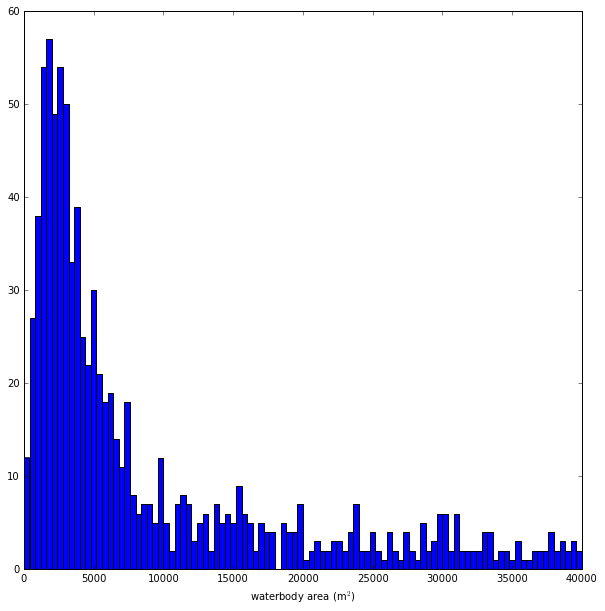

In [6]:
print( "Unique perennial flags:", list(set(peren_list)) )

plt.hist(np.array(shape_list),bins=100,range=(0,40000));
plt.xlabel("waterbody area (m$^2$)");

It was suggested by DPI Water to originally focus on perennial waterbodies with areas of more than 5000 m$^2$...

In [7]:
idx = (np.array(shape_list)>=5000)
tmp = sum( (np.array(peren_list)=='Perennial') & idx )
print("There are {} perennial lakes with area of more than 5000 sq.m.".format(tmp))
print("Average lake area (sq.m):", round( np.mean(np.array(shape_list)) ) )
print("Average lake area of lakes above 5000 sq.m:", round( np.mean(np.array(shape_list)[idx]) ) )

There are 912 perennial lakes with area of more than 5000 sq.m.
Average lake area (sq.m): 3346303.0
Average lake area of lakes above 5000 sq.m: 4422323.0


Some more investigation of the dataset...

In [8]:
# # Print all names in alphabetical order:
# tmp = np.sort(lname_list)
# for ii in tmp: print(ii)

In [9]:
# Find the first instance of a given name:
ftr = lname_list.index('LAKE WINDAMERE'); print(ftr)
ftr = lname_list.index('LAKE CARGELLIGO'); print(ftr)
ftr = lname_list.index('LAKE LIDDELL'); print(ftr)
ftr = lname_list.index('LAKE HUME'); print(ftr)
ftr = lname_list.index('LAKE WYANGAN'); print(ftr)
ftr = lname_list.index('BLOWERING'); print(ftr)
# ftr = lname_list.index('LOSTOCK'); print(ftr)

752
572
1371
1368
595
715


In [10]:
# Find index of specific lakes of interest (partial match):

#indx = [i for i, s in enumerate(lname_list) if 'BLOWERING' in s]
indx = [i for i, s in enumerate(lname_list) if 'WINDAMERE' in s]

print(indx)
print( [ lname_list[ii] for ii in indx ] )

[752, 1913]
['LAKE WINDAMERE', 'LAKE WINDAMERE']


This result points to a potential issue that could arise from two different features having the same name in the dataset (e.g. if creating a folder or `.nc` dataset name after the first feature instance, processing of the second instance would overwrite the original dataset). 

Let's check whether these two features correspond to the same or different polygons...

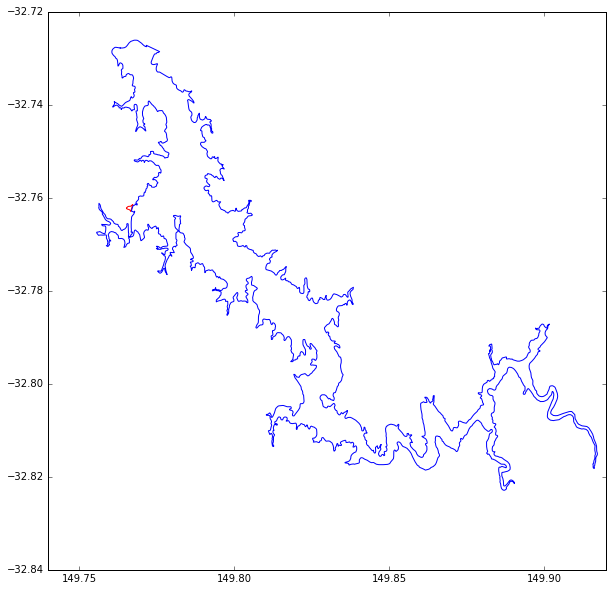

In [11]:
lakes_ftr = lakes_lyr.GetFeature(indx[0])
ring = lakes_ftr.GetGeometryRef().GetGeometryRef(0)
poly_array1 = np.array(ring.GetPoints())[:,0:2]  # lon / lat coords of polygon

ftr = indx[1]
lakes_ftr = lakes_lyr.GetFeature(indx[1])
ring = lakes_ftr.GetGeometryRef().GetGeometryRef(0)
poly_array = np.array(ring.GetPoints())[:,0:2]  # lon / lat coords of polygon

plt.plot(poly_array1[:,0], poly_array1[:,1],'r',poly_array[:,0], poly_array[:,1],'b');

OK, so we definitely have 2 separate shapes here, so we'll assume that duplicate names have to be somehow treated separately.  
<br>
<div class=warn>
<b>TO DO:</b> we will need to deal properly with duplicate waterbody names in the DPI Water .shp file.
</div>

## Some LS8 data

Well work with the example waterbody used in the previous notebook _"AEWS Python Notebook 08c"_. Let's first load some Landsat data...

In [12]:
ftr = lname_list.index('WONGALARA')
lakes_ftr = lakes_lyr.GetFeature(ftr)
ring = lakes_ftr.GetGeometryRef().GetGeometryRef(0)
poly_array = np.array(ring.GetPoints())[:,0:2]  # lon / lat coords of polygon

In [13]:
dc = datacube.api.API()

In [14]:
dimensions = { 'lon' : { 'range': ( min(poly_array[:,0])-0.02, max(poly_array[:,0])+0.02 ) },
               'lat' : { 'range': ( max(poly_array[:,1])+0.02, min(poly_array[:,1])-0.02 ) },
               'time': { 'range': ((2013, 7, 1), (2013, 8, 1)) } }
query = { 'product': 'nbar',
          'platform': 'LANDSAT_8',
          'dimensions': dimensions }
desc = dc.get_descriptor(query, include_storage_units=False)
print( "Nr. available dates:", desc['ls8_nbar_albers']['result_shape'][0])

Nr. available dates: 14


In [15]:
ae = AnalyticsEngine(); ee = ExecutionEngine()
aeB2 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_3'], dimensions, 'aeB2')
aeB3 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_4'], dimensions, 'aeB3')
aeB7 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_7'], dimensions, 'aeB7')   # SWIR2 band
aePQ = ae.create_array(('LANDSAT_8', 'pqa'), ['pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([aeB2, aeB3], '((array1 + array2) * 0.5)', 'aeWQ')
aeWQ_PQmsk = ae.apply_expression([aeWQ, aePQ], 'array1{array2}', 'aeWQ_PQmsk')
aeB7_PQmsk = ae.apply_expression([aeB7, aePQ], 'array1{array2}', 'aeB7_PQmsk')
ee.execute_plan(ae.plan)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


In [16]:
# Merge datasets with duplicated dates:
B7_pqm_xarray = ee.cache['aeB7_PQmsk']['array_result'].values()[0]  # 'band_7' ...!
B7_pqm_xarray = merge_dup_dates( B7_pqm_xarray.load() )
WQ_pqm_xarray = ee.cache['aeWQ_PQmsk']['array_result'].values()[0]
WQ_pqm_xarray = merge_dup_dates( WQ_pqm_xarray.load() )
print( "Nr. available dates:", B7_pqm_xarray.shape[0])

Nr. available dates: 6


In [17]:
# Remove time slices with only NaN pixels:
tmp = np.where( ( (~np.isnan(B7_pqm_xarray)).sum('x').sum('y')!=0 ).values )[0]
B7_pqm_xarray = B7_pqm_xarray[tmp]
tmp = np.where( ( (~np.isnan(WQ_pqm_xarray)).sum('x').sum('y')!=0 ).values )[0]
WQ_pqm_xarray = WQ_pqm_xarray[tmp]
print( "Nr. available dates:", B7_pqm_xarray.shape[0])

Nr. available dates: 4


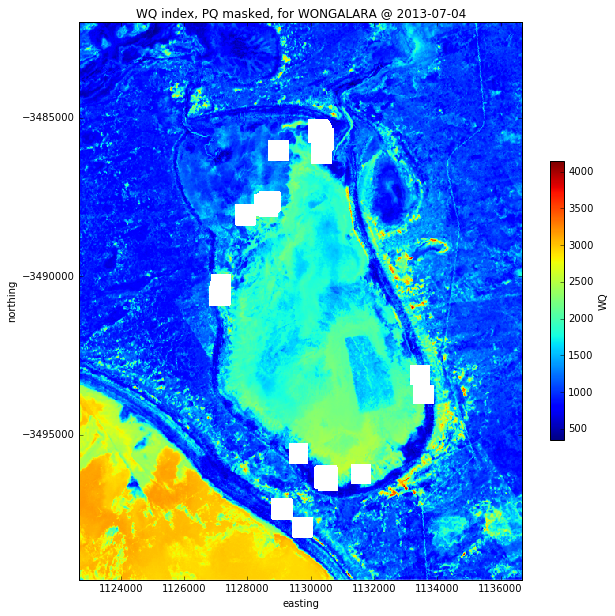

In [18]:
date_ind = 0
xvec = B7_pqm_xarray.coords['x']; yvec = B7_pqm_xarray.coords['y']

plt.imshow( WQ_pqm_xarray[date_ind], interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
pq_datestr = str(WQ_pqm_xarray.coords['time'][date_ind].values)[:10]
plt.title( 'WQ index, PQ masked, for {} @ {}'.format(lname_list[ftr], pq_datestr) )
plt.ylabel('northing'); plt.xlabel('easting')
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ');

In [19]:
# Reproject WQ data:
LS_data = dc.get_data( query )
LS_proj_str = LS_data['coordinate_reference_systems'][1]['reference_system_definition']
LS_proj = osr.SpatialReference( wkt=LS_proj_str )   # will hopefully be part of the ee.cache results at some stage

LSxvec = WQ_pqm_xarray['x'].values; LSyvec = WQ_pqm_xarray['y'].values
LSpix_size = np.mean(LSxvec[1:] - LSxvec[:-1])
LS_geotx = ( LSxvec[0], LSpix_size, 0, LSyvec[0], 0, -LSpix_size )

# WQ gdal dataset
tmp, WQ_nr, WQ_nc = WQ_pqm_xarray.shape
gdal_data = gdal.GetDriverByName( 'MEM' ).Create('', WQ_nc, WQ_nr, 1, gdal.GDT_Float32)
gdal_data.SetGeoTransform( LS_geotx )
gdal_data.SetProjection( LS_proj.ExportToWkt() )
gdal_data.GetRasterBand(1).WriteArray( WQ_pqm_xarray[date_ind].values, 0, 0)

# Reprojection variables
dst_proj = osr.SpatialReference ()
dst_proj.ImportFromEPSG ( 4326 )

# Coordinate transformtion from 'src_proj' to 'dst_proj':
proj_tx = osr.CoordinateTransformation( LS_proj, dst_proj )
ulx, uly, ulz = proj_tx.TransformPoint( LS_geotx[0], LS_geotx[3] )
lrx, lry, lrz = proj_tx.TransformPoint( LS_geotx[0] + LS_geotx[1]*(WQ_nc-1), LS_geotx[3] + LS_geotx[5]*(WQ_nr-1) )

dd = 0.00025   # geodetic pixel spacing
geo_nr = int( (uly-lry)/dd )
geo_nc = int( (lrx-ulx)/dd )

# Reprojection variables
gdalgeo_data = gdal.GetDriverByName( 'MEM' ).Create('', geo_nc, geo_nr, 1, gdal.GDT_Float32)
gdalgeo_data.SetGeoTransform( (ulx, dd, 0, uly, 0, -dd) )
gdalgeo_data.SetProjection( dst_proj.ExportToWkt() )

# Reprojecting the WQ gdal dataset to match the WOFS coordinates:
gdalgeo_data.GetRasterBand(1).WriteArray( np.ones((geo_nr,geo_nc))*np.nan, 0, 0)
res = gdal.ReprojectImage( gdal_data, gdalgeo_data,
                           LS_proj.ExportToWkt(), dst_proj.ExportToWkt(),
                           gdal.GRA_Bilinear )   # gdal.GRA_NearestNeighbour by default

WQ_array = gdalgeo_data.ReadAsArray()   # reprojected result
x_vec = np.arange(geo_nc)*dd+ulx
y_vec = uly-np.arange(geo_nr)*dd

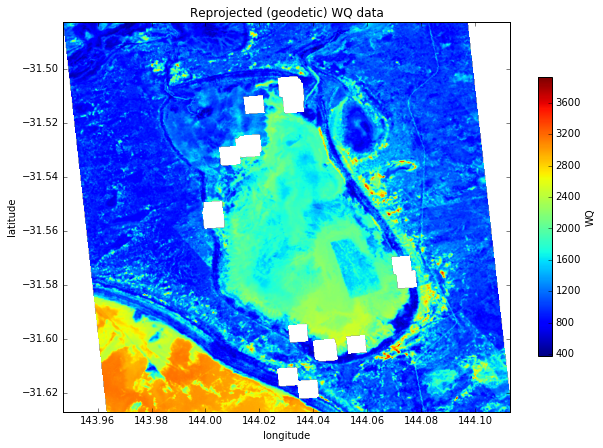

In [20]:
plt.imshow(WQ_array, extent=[x_vec[0],x_vec[-1],y_vec[-1],y_vec[0]])
plt.title('Reprojected (geodetic) WQ data')
plt.ylabel('latitude'); plt.xlabel('longitude');
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ');

In [21]:
# Reproject the LS8 Band 7 data to be able to generate the SWIR filter mask:
gdal_data.GetRasterBand(1).WriteArray( B7_pqm_xarray[date_ind].values, 0, 0)

gdalgeo_data.GetRasterBand(1).WriteArray( np.ones((geo_nr,geo_nc))*np.nan, 0, 0)
res = gdal.ReprojectImage( gdal_data, gdalgeo_data,
                           LS_proj.ExportToWkt(), dst_proj.ExportToWkt(),
                           gdal.GRA_Bilinear )   # gdal.GRA_NearestNeighbour by default
B7_pqm_array = gdalgeo_data.ReadAsArray()   # reprojected result

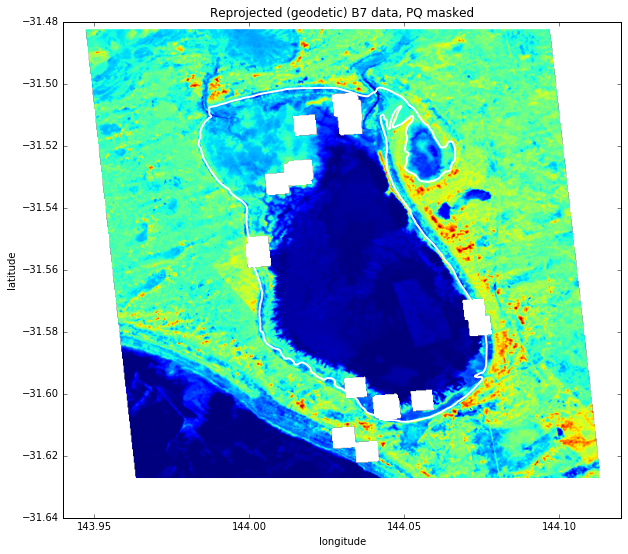

In [22]:
plt.imshow(B7_pqm_array, extent=[x_vec[0],x_vec[-1],y_vec[-1],y_vec[0]])
plt.title('Reprojected (geodetic) B7 data, PQ masked')
plt.ylabel('latitude'); plt.xlabel('longitude');
plt.plot(poly_array[:,0], poly_array[:,1],'w', linewidth=2);   # superimposed polygon

## Polygon mask

As discussed in the previous notebook _"AEWS Python Notebook 08c"_, we could use the waterbody polygon (instead of WOFS) to mask out the land pixels. We can do this using some standard 'point-in-polygon' test, for instance using the `matplotlib.path` functions:

In [23]:
%%time
shp = WQ_array.shape
polyPath = Path(poly_array)
poly_mask = np.zeros(shp, dtype='bool')
for ii in range(shp[0]):
    for jj in range(shp[1]):
        if not polyPath.contains_point([x_vec[jj],y_vec[ii]]):
            poly_mask[ii,jj] = True   # mask land pixels

CPU times: user 1min 24s, sys: 1.06 s, total: 1min 25s
Wall time: 1min 22s


The execution time seems somewhat excessive here... We can shorten this in a number of ways, e.g. by only processing the pixels within the lat/lon range of the polygon:

In [24]:
%%time
polyPath = Path(poly_array)
poly_mask = np.ones(WQ_array.shape, dtype='bool')

jj1 = np.where( x_vec<min(poly_array[:,0]) )[0][-1]
jj2 = np.where( x_vec>max(poly_array[:,0]) )[0][0]
ii2 = np.where( y_vec<min(poly_array[:,1]) )[0][0]
ii1 = np.where( y_vec>max(poly_array[:,1]) )[0][-1]

for ii in range(ii1,ii2+1):   #range(shp[0]):
    for jj in range(jj1,jj2+1):   #range(shp[1]):
        if polyPath.contains_point([x_vec[jj],y_vec[ii]]):
            poly_mask[ii,jj] = False   # unmask water pixels

CPU times: user 36.5 s, sys: 527 ms, total: 37 s
Wall time: 35.4 s


That's a bit better, but it's likely that the looping over every single point is a bottelneck. Let's vectorise the inside loop:

In [25]:
%%time
polyPath = Path(poly_array)
poly_mask = np.ones(WQ_array.shape, dtype='bool')

jj1 = np.where( x_vec<min(poly_array[:,0]) )[0][-1]
jj2 = np.where( x_vec>max(poly_array[:,0]) )[0][0]
ii1 = np.where( y_vec>max(poly_array[:,1]) )[0][-1]
ii2 = np.where( y_vec<min(poly_array[:,1]) )[0][0]
njj = jj2 - jj1 + 1

for ii in range(ii1,ii2+1):
    tmp = np.stack((x_vec[jj1:jj2+1], y_vec[ii]*np.ones(njj)),axis=1)
    poly_mask[ii,jj1:jj2+1] = ~polyPath.contains_points(tmp)

CPU times: user 3.56 s, sys: 10 ms, total: 3.57 s
Wall time: 3.5 s


That's much better! But can we do even more by vectorising the whole thing?...

In [26]:
%%time
polyPath = Path(poly_array)
poly_mask = np.ones(WQ_array.shape, dtype='bool')

jj1 = np.where( x_vec<min(poly_array[:,0]) )[0][-1]
jj2 = np.where( x_vec>max(poly_array[:,0]) )[0][0]
ii1 = np.where( y_vec>max(poly_array[:,1]) )[0][-1]
ii2 = np.where( y_vec<min(poly_array[:,1]) )[0][0]
njj = jj2 - jj1 + 1
nii = ii2 - ii1 + 1

tmp = np.stack( ( np.tile(x_vec[jj1:jj2+1],nii), np.repeat(y_vec[ii1:ii2+1],njj) ) ,axis=1)
tmp = ~polyPath.contains_points(tmp)
poly_mask[ii1:ii2+1,jj1:jj2+1] = tmp.reshape(nii,njj)

CPU times: user 3.44 s, sys: 0 ns, total: 3.44 s
Wall time: 3.44 s


Well, not much gained there, but we'll go with this anyway (speed-up factor of 25 compared to original test). Let's check that the polygon mask looks OK:

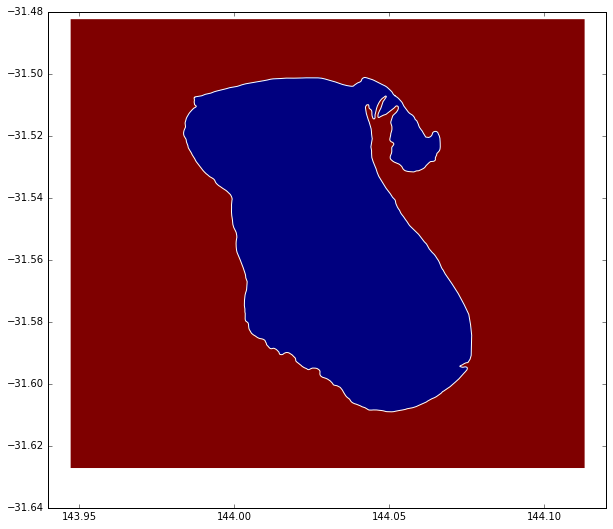

In [27]:
plt.imshow(poly_mask, extent=[x_vec[0],x_vec[-1],y_vec[-1],y_vec[0]])
plt.plot(poly_array[:,0], poly_array[:,1], 'w');   # superimposed polygon

We can now apply this polygon mask to the WQ data:

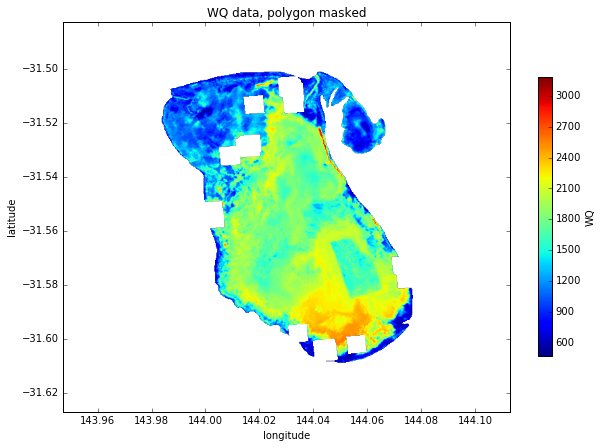

In [28]:
WQ_array_pmsk = WQ_array.copy()
WQ_array_pmsk[poly_mask] = np.nan

plt.imshow(WQ_array_pmsk, extent=[x_vec[0],x_vec[-1],y_vec[-1],y_vec[0]])
plt.title('WQ data, polygon masked')
plt.ylabel('latitude'); plt.xlabel('longitude');
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ');

## SWIR filter

As per the _"AEWS Python Notebook 08b"_, the SWIR filter mask is derived from the LS8 band 7 data using a 1% threshold. We can apply it to the WQ data as follows:

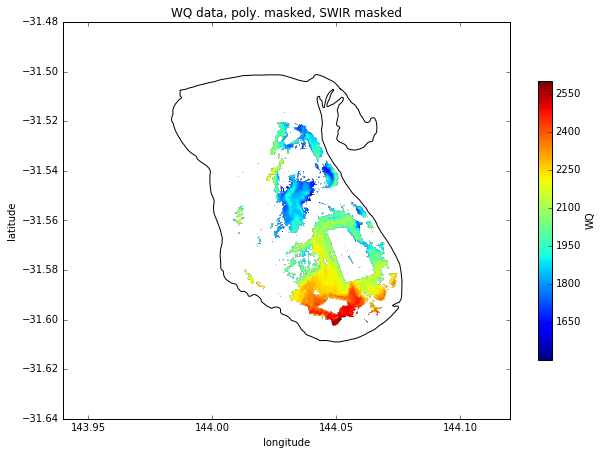

In [29]:
SWIR_mask = ( B7_pqm_array>100 )

WQ_array_pmsk_SWIRmsk = WQ_array_pmsk.copy()
WQ_array_pmsk_SWIRmsk[SWIR_mask] = np.nan

plt.imshow(WQ_array_pmsk_SWIRmsk, extent=[x_vec[0],x_vec[-1],y_vec[-1],y_vec[0]])
plt.title('WQ data, poly. masked, SWIR masked')
plt.ylabel('latitude'); plt.xlabel('longitude');
plt.plot(poly_array[:,0], poly_array[:,1], 'k');   # superimposed polygon
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ');

As discussed in _"AEWS Python Notebook 08c"_, the availability of lake polygons represents an improvement on the use of WOFS data. First, it allows us to properly extract the lake of interest (rather than all / any water pixel in the ROI, as delivered by WOFS). In the above example, for instance, the section of waterbody in the lower-left corner of the ROI is properly removed when generating the WQ map for the lake of interest.

Also, we can now also derive a "proper" low-water flag on the basis of the polygon mask. 


## Low-water flag

If we assume that the lake polygon corresponds to the "100% full" water level, a low-water flag can be derived simply by comparing the extents of 'valid' pixels in the polygon and SWIR masks. 

Note that we have to carefully consider NaN values here, e.g. as a result of masking clouds and cloud shadows. Witin the polygon extents, we can only compare non-NaN values, and we cannot assume anything about the NaN data, i.e. whether the masked areas represent water pixels or not. 

For instance, let's assume that the low-water flag is triggered when the extents of water within the polygon dropps below X % (e.g. 80%). The following procedure can be used to determine the low-water flag:

- If the percentage Y of NaN pixels within the polygon is less than 100-X % (e.g.Y=10%):  
    1. low-water flag is TRUE if percentage of water pixels within polygon is below X %  
    2. low-water flag is FALSE if percentage of water pixels within polygon is above X %  
- If the percentage Y of NaN pixels within the polygon is more than 100-X % (e.g. Y=30%):  
    1. low-water flag is TRUE if percentage of water pixels within polygon is below 100-Y %  
    2. low-water flag is UNDEFINED if percentage of water pixels within polygon is equal to 100-Y %

Let's see how this is applied to the above example, using an arbitrary low-water threshold of 90%.

In [30]:
low_water_thr = 90.0

In [31]:
n_water_pix_poly = np.sum(~poly_mask)   # total nr of water pixels within polygon mask

n_water_pix_poly_nonNaN = np.sum(~np.isnan(WQ_array_pmsk))   # nr of non-NaN water pixels in polygon
n_water_pix_poly_NaN = n_water_pix_poly - n_water_pix_poly_nonNaN   # nr of NaN water pixels in polygon

n_water_pix_SWIR = np.sum(~np.isnan(WQ_array_pmsk_SWIRmsk))  # nr of water pix within polygon, as per SWIR filter

nan_pix_prct = 100.0*n_water_pix_poly_NaN/n_water_pix_poly   # percentage of NaN pixels within poly
water_pix_prct = 100.0*n_water_pix_SWIR/n_water_pix_poly     # percentage of SWIR water pixels within poly

if nan_pix_prct<=(100.0-low_water_thr):
    if water_pix_prct<low_water_thr:
        low_water_flag = 'true'
    else:
        low_water_flag = 'false'
else:
    if water_pix_prct<(100.0-nan_pix_prct):
        low_water_flag = 'true'
    else:
        low_water_flag = 'undefined'

In [32]:
print( "Percentage of NaN pixels in waterbody: {}%".format(round(nan_pix_prct,1)) )
print( "Percentage of SWIR water pixels in waterbody: {}%".format(round(water_pix_prct,1)) )
print( "The waterbody has a low water level:", low_water_flag)

Percentage of NaN pixels in waterbody: 8.5%
Percentage of SWIR water pixels in waterbody: 21.2%
The waterbody has a low water level: true
